# LSTM (장단기기억Long Short-Term Memory)

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import pandas as pd

In [2]:
df_ss = pdr.get_data_yahoo('005930.KS','20200101','20201231')

In [3]:
df_ss

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,56000.0,55000.0,55500.0,55200.0,12993228.0,52537.179688
2020-01-03,56600.0,54900.0,56000.0,55500.0,15422255.0,52822.707031
2020-01-06,55600.0,54600.0,54900.0,55500.0,10278951.0,52822.707031
2020-01-07,56400.0,55600.0,55700.0,55800.0,10009778.0,53108.238281
2020-01-08,57400.0,55900.0,56200.0,56800.0,23501171.0,54059.992188
...,...,...,...,...,...,...
2020-12-23,74000.0,72300.0,72400.0,73900.0,19411326.0,71766.921875
2020-12-24,78800.0,74000.0,74100.0,77800.0,32502870.0,75554.351562
2020-12-28,80100.0,78200.0,79000.0,78700.0,40085044.0,76428.375000


In [4]:
window_size = 10  # 이전 10일 동안 데이터를 이용
data_size = 6     # (high~adj close까지해서 6개)

In [5]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

In [6]:
dfx = MinMaxScaler(df_ss)
dfy = dfx[['Close']]

x = dfx.values.tolist()
y = dfy.values.tolist()

In [7]:
df_ss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-01-02 to 2020-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       248 non-null    float64
 1   Low        248 non-null    float64
 2   Open       248 non-null    float64
 3   Close      248 non-null    float64
 4   Volume     248 non-null    float64
 5   Adj Close  248 non-null    float64
dtypes: float64(6)
memory usage: 13.6 KB


In [8]:
data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)
print(_x, "->", _y) 
#마지막으로 data_x 리스트에 추가된 _x 값과 data_y 리스트에 추가된 _y값 확인

[[0.8092715231766642, 0.8635097493012158, 0.8571428571405023, 0.8129870129849013, 0.35086851501253674, 0.7767744515079114], [0.8198675496667023, 0.8662952646215424, 0.865384615382238, 0.8129870129849013, 0.29450415774142813, 0.7767744515079114], [0.798675496686626, 0.8440111420589304, 0.8461538461515216, 0.799999999997922, 0.40854382342693996, 0.7646931332907858], [0.798675496686626, 0.8551532033402364, 0.8434065934042764, 0.7922077922057346, 0.29620182038447335, 0.7574444978647431], [0.7907284768190974, 0.8272980501369713, 0.8379120879097859, 0.7922077922057346, 0.3425218698848906, 0.7574444978647431], [0.7854304635740783, 0.8300835654572978, 0.8214285714263148, 0.7740259740239636, 0.27420292234828, 0.7405304968565346], [0.8066225165541546, 0.8356545960979508, 0.8186813186790696, 0.8155844155822972, 0.32644413957851637, 0.779190598523162], [0.9337748344346125, 0.8830083565435014, 0.865384615382238, 0.9168831168807353, 0.546607245222834, 0.8734244141040435], [0.9682119205272365, 0.9999

- 가장 마지막날 종가 0.9331193789448738, 10일동안 매핑되는 다음날 종가9999999999975119

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

In [11]:
# 모델 생성
model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(window_size, data_size)))
model.add(Dropout(0.1)) # Dropout층은 입력값의 일부분을 선택해서 그 값음0으로 치환하여 다음층으로 출력함으로써 훈련 데이터를 늘리지않고 과적합 방지 가능
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1)) # 유닛이 하나인 출력층을 추가
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=60, batch_size=30)
pred_y = model.predict(test_x)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 10)            680       
_________________________________________________________________
dropout (Dropout)            (None, 10, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,531
Trainable params: 1,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
6/6 [==============================] - 7s 14ms/step - loss: 0.1006
Epoch 2/60
6/6 [==========================

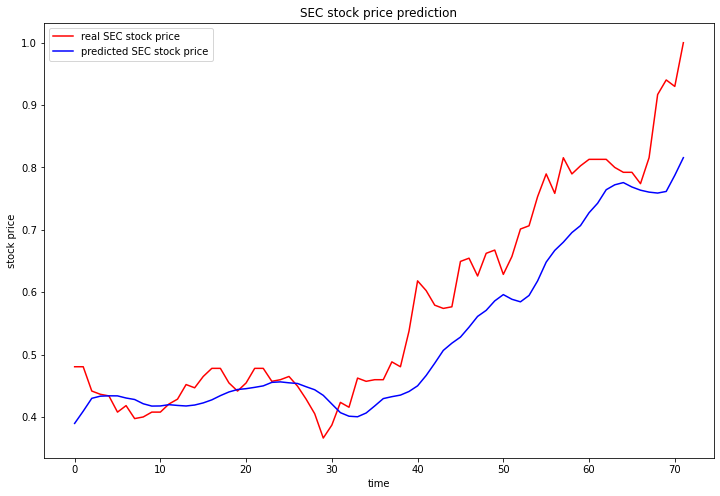

Tomorrow's SEC price : [66069.06] KRW


In [15]:
# 실제 종가와 예측치를 그래프로 비교
plt.figure(figsize=(12,8))
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# raw_df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print("Tomorrow's SEC price :", df_ss['Close'][-1] * pred_y[-1] / dfy['Close'][-1], 'KRW')